In [1]:
## SIMULATION PARAMETERS
verbosity         = 6        # Set debug print statement verbosity level (0 = Standard, -1 = Off)
use_mass_units    = True     # Toggle whether calculations / results are given in units of pi-axion mass (True) or eV (False)
use_natural_units = True     # Toggle whether calculations / results are given in c = h = G = 1 (True) or SI units (False)   || NOTE: full SI/phsyical unit support is still WIP!!
save_output_files = True     # Toggle whether or not the results from this notebook run are written to a data directory
use_logsumexp     = True    # Toggle whether or not numerical integrations are performed in log-scale number space (increases computation time)

config_name = 'pi_axiverse_jupyter_debug'   # Descriptive name for the given parameter case. Output files will be saved in a directory with this name.
#seed = None                  # rng_seed, integer value (None for random)
#seed = 191281265662032962853842089260008419904
seed = 273518240747739694407649543037978030233
num_cores = 100              # Number of parallel threads available
#density = 1e22                # Local DM energy density (in [Gev/cm^3])
use_tex_format = True

In [2]:
# System Configuration Printouts
from piaxi_utils import version, default_output_directory

data_path = default_output_directory
version   = version

if verbosity >= 2:
    print('version %s' % version)
    print('save path: %s' % data_path)

version v3.2.6
save path: ~/scratch


In [3]:
# Imports and Initialization
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
from scipy.optimize import curve_fit
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.cm as cm
from piaxi_numerics import solve_piaxi_system
from piaxi_utils import *
from piaxiverse import *
import os

debug_level = verbosity
unitful_masses = True    # Toggle whether to provide unitful [eV] masses vs. mass-ratio [m_unit] values for calculations (Default: True)
unitful_k = False        # Toggle whether k values are defined unitfully [eV] vs. units of mass-ratio [m_unit] (Default: False)

rng, rng_seed = get_rng(seed=seed, verbosity=verbosity)

rng_seed: 273518240747739694407649543037978030233


In [4]:
# LaTeX Formatting for Plots
if use_tex_format:
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    '''plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)  # fontsize of the figure title'''

In [5]:
# Unitful fundamental constants
c_raw = c = np.float64(2.998e10)    # Speed of light in a vacuum [cm/s]
h_raw = h = np.float64(4.136e-15)   # Planck's constant [eV/Hz]
G_raw = G = np.float64(1.0693e-19)  # Newtonian constant [cm^5 /(eV s^4)]
manual_set = False
if manual_set: # Manually toggle units
    unitful_c = False
    unitful_h = False
    unitful_G = False
if use_natural_units:
    unitful_c = unitful_h = unitful_G = False
else:
    unitful_c = unitful_h = unitful_G = True

# values to use in calculations in order to ensure correct units
c_u = c if unitful_c else 1.
h_u = h if unitful_h else 1.
G_u = G if unitful_G else 1.

In [6]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 1e10     # pi-axion decay constant (GeV) >= 10^11
#F    = 1e11     # pi-axion decay constant (GeV) >= 10^11
#p_t  = 1e22     # total local DM density (GeV/cm^3)
p_t = 1e20
#p_unit = 1.906e-12
dimensionful_p = not(use_natural_units)
p_unit = (c_raw*h_raw)**3 if not(dimensionful_p) else 1.   # convert densities from units of [1/cm^3] to [eV^3]
## --> TODO: Could/Should we support spatially dependent distributions?

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
#L3   = 1e11    # (GeV)
L3   = 1e11
#L4   = 1e11    # (GeV)
L4   = 1e30
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
p_t *= p_unit  # 1/cm^3 -> (eV/hc)^3
L3  *= GeV
L4  *= GeV

# Manually disable any terms from equations of motion
disable_P = False
disable_B = False
disable_D = False
disable_C = False

In [7]:
## Dark SM Parameters
sample_qmass = False # TODO
sample_qcons = False
# Mass scaling parameters
m_scale = 1e-80            # dark quark mass scale (eV) <= 10-20

# SM quark masses for all 3 generations
qm = m_scale*np.array([1., 2., 40.]) if not sample_qmass else m_scale*np.array([0., 0., 0.]) # TODO

# dSM quark scaling constants (up, down, strange, charm, bottom, top) sampled from uniform distribution [0.7, 1.3]
qc = np.array([1., 1., 1., 0., 0., 0.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))
#qc = np.array([1., 1., 1., 1., 1., 1.]) if not sample_qcons else rng.uniform(0.7, 1.3, (6,))

# Dark quark masses (up, down, strange, charm, bottom, top)
dqm = np.array([qm[0]*qc[0], qm[0]*qc[1], qm[1]*qc[2], qm[1]*qc[3], qm[2]*qc[4], qm[2]*qc[5]])

# Scaling parameters
xi     = np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])  # Charged species scaling paramters
eps_c  = np.array([+1., +1., +1., -1., -1., -1., -1., +1., -1.])  # Millicharge sign

In [8]:
# Time domain
# TODO: How many oscillations do we want to capture in the time period?
#       Do we want to run each simulation until it hits time t' or until it completes T oscillations?
t_span = [0, 30]   # Units of 1/m_u
#t_N    = 1000       # Number of timesteps
t_N = 1000
t_sens = 0.2       # fraction of total time to use to calculate (averaged) initial and final occupation numbers (0.1 = first/last 10%)

# k values
# TODO: Should we run k up until we hit the cutoff limit? If not, what limit?
use_k_eq_0 = False     # Toggle whether or not k = 0 is included in the numerics (div. by 0 error possible if on)
k_min = 0 if use_k_eq_0 else 1
k_max = 100
k_span = [k_min, k_max]  # TODO: replace with the appropriate values
k_res = 0.1                            # k-mode granularity
k_N = int((1./k_res)*max((k_max - k_min), 0) + 1)    # Number of k-modes
#k_N = 200

In [9]:
# Initial Conditions
A_0    = 1.0
Adot_0 = 1.0

A_pm   = +1       # specify A± case (+1 or -1)
A_sens = 1.0      # sensitivity for classification of resonance conditions
em_bg  = 1.0      # Photon field background

In [10]:
# Toggle whether mass-energy values should be computed in units of eV (False) or pi-axion mass (True)
# (by default, k is defined in units of [m_u] whereas m is defined in units of [eV], so their scaling logic is inverted)
unitful_amps   = unitful_m = unitful_masses
rescale_m      = use_mass_units if unitful_masses else not(use_mass_units)
rescale_k      = not(rescale_m) if unitful_masses else rescale_m
rescale_amps   = use_mass_units if unitful_amps else not(use_mass_units)

In [11]:
# Define pi-axiverse mass species
m_r, m_n, m_c, counts, masks = define_mass_species(qm=qm, qc=qc, F=F, e=e, eps=eps, eps_c=eps_c, xi=xi)
N_r, N_n, N_c = counts

In [12]:
## Override Mass Species
mask_reals   = False
mask_complex = False
mask_charged = False

if mask_reals: # Mask all real neutral species (for multi-field axion models)
    m_r = np.ma.masked_where(True, m_r, copy=True)
    N_r = 0
    masks[0] = np.ma.getmaskarray(m_r)
if mask_complex: # Mask all complex neutral species (for multi-field axion models)
    m_n = np.ma.masked_where(True, m_n, copy=True)
    N_n = 0
    masks[1] = np.ma.getmaskarray(m_n)
if mask_charged: # Mask all complex neutral species (for multi-field axion models)
    m_c = np.ma.masked_where(True, m_c, copy=True)
    N_c = 0
    masks[2] = np.ma.getmaskarray(m_c)

if N_r <= 0:
    disable_C = True
if N_c <= 0:
    disable_D = True

In [13]:
## Get variables of model

# Populate masses for real, complex, and charged species (given in units of eV)
m, m_u = init_masses(m_r, m_n, m_c, natural_units=use_natural_units, c=c, verbosity=verbosity)
# Handle unit rescaling logic
m_unit = m_u

m0     = m0_f(m_u, c_u, rescale_m, unitful_m)      # Desired units  (m --> m_u)
m0_raw = m0_f(m_u, c_raw, True, unitful_m)         # Physical units (eV/c^2)
k0     = k0_f(m_u, c_u, rescale_k, unitful_m)      # Desired units  (k --> m_u)
k0_raw = k0_f(m_u, c_raw, True, unitful_m)         # Physical units (eV/c)
t0     = t0_f(m_u, h_u, rescale_m, unitful_m)      # Desired units  (t --> 1/m_u)
t0_raw = t0_f(m_u, h_raw, True, unitful_m)         # Physical units (s)

if verbosity >= 2:
    print('c = %.4g  | c_u = %.2g | c_raw = %.2g' % (c, c_u, c_raw))
    print('h = %.4g  | h_u = %.2g | h_raw = %.2g' % (h, h_u, h_raw))
    print('G = %.4g  | G_u = %.2g | G_raw = %.2g' % (G, G_u, G_raw))
    print('m_u       : %.2g' % m_u)
    print('m_0       : %.2g' % m0)
    print('m_0 (raw) : %.2g' % m0_raw)
    print('k_0       : %.2g' % k0)
    print('k_0 (raw) : %.2g' % k0_raw)
    print('t_0       : %.2g' % t0)
    print('t_0 (raw) : %.2g' % t0_raw)

## Populate pi-axion dark matter energy densities
p = init_densities(masks, p_t=p_t, normalized_subdens=True)

## Populate (initial) pi-axion dark matter mass-amplitudes for each species, optional units of [eV/c]
amps = init_amplitudes(m, p, m_unit=m_u, h=h, c=c, mass_units=use_mass_units, natural_units=use_natural_units, unitful_amps=unitful_masses, rescale_amps=rescale_amps, verbosity=verbosity)

freeze_Theta = False
freeze_Theta_val = np.pi
if freeze_Theta:
    Th_in = np.array([np.ma.masked_where(masks[0], np.full_like(masks[0], freeze_Theta_val, dtype=float)).compressed(),
                      np.ma.masked_where(masks[1], np.full_like(masks[1], freeze_Theta_val, dtype=float)).compressed(),
                      np.ma.masked_where(masks[2], np.full_like(masks[2], freeze_Theta_val, dtype=float)).compressed()], dtype=object)
    sample_Theta = False
else:
    Th_in = None
    sample_Theta = True

# Populate and sample local and global phases from normal distribution, between 0 and 2pi
d, Th = init_phases(masks, rng=rng, sample_delta=True, sample_Theta=sample_Theta, Theta_in=Th_in, verbosity=verbosity, sample_dist='uniform')

# For performance gains, omit fully non-existant species from the numerics
m    = trim_masked_arrays(m)
p    = trim_masked_arrays(p)
amps = trim_masked_arrays(amps)
Th   = trim_masked_arrays(Th)
d    = trim_masked_arrays(d)

m_unit:   4.472135954999579e-31
m (raw):
 [array([4.47213595e-31, 6.32455532e-31]) array([5.47722558e-31])
 array([], dtype=float64)]
m (out):
 [array([4.47213595e-31, 6.32455532e-31]) array([5.47722558e-31])
 array([], dtype=float64)]
c = 2.998e+10  | c_u = 1 | c_raw = 3e+10
h = 4.136e-15  | h_u = 1 | h_raw = 4.1e-15
G = 1.069e-19  | G_u = 1 | G_raw = 1.1e-19
m_u       : 4.5e-31
m_0       : 2.2e+30
m_0 (raw) : 2.5e+09
k_0       : 1
k_0 (raw) : 1.5e-41
t_0       : 2.2e+30
t_0 (raw) : 9.2e+15
amps (raw):
 [array([9.76344851e+38, 6.90380065e+38]) array([1.12738592e+39])
 array([], dtype=float64)]
amps (out):
 [array([2.18317346e+69, 1.54373675e+69]) array([2.52091156e+69])
 array([], dtype=float64)]
Sample delta?   True (uniform distribution)
delta (out):
 [array([0.56936819, 1.50716719]) array([0.56095685])
 array([], dtype=float64)]
Sample Theta?   True (uniform distribution)
Theta (out):
 [array([4.72832587, 2.92510511]) array([1.6662435])
 array([], dtype=float64)]


In [14]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_±} respectively

# Rescale all eV unit constants to unit mass
#rescale_consts = False
rescale_consts = rescale_m if unitful_masses else not(rescale_m)
L3_sc = abs(L3) if not rescale_consts else L3 / m_unit
L4_sc = abs(L4) if not rescale_consts else L4 / m_unit
F_sc  = abs(F)  if not rescale_consts else  F / m_unit

# Characteristic timescales (minimum binsize to capture full oscillations) by species
T_min, T_r, T_n, T_c = get_timescales(m, m0, m_u=1, verbosity=verbosity)

units = get_units(unitful_m, rescale_m, unitful_k, rescale_k, unitful_amps, rescale_amps, rescale_consts, dimensionful_p, unitful_c, unitful_h, unitful_G, use_mass_units, verbosity=verbosity)
print_params(units, m=m, p=p, amps=amps, Th=Th, d=d, m_q=m_scale, m_0=m0, m_u=m_u, natural_units=use_natural_units, verbosity=verbosity)

# Shorthand helper function for oscillatory time-dependent terms
# (time is assumed to be defined in units of [1/m_u] always)
phi = lambda t, s, i, m=m, d=d, t0=t0: (m[s][i]*t*t0) + d[s][i]
#phi = lambda t, s, i, m=m, d=d, M=(1./m_unit if unitful_masses and not rescale_m else 1.): (m[s][i]*M)*t + d[s][i]

# Define coefficient functions to clean up differential equation representation
P = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
           2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                            for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
           2*l4/(L4**2) * eps**2 * (np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(phi(t,1,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][i]-Th[1][j]) \
                                            for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                    np.sum([amps[0][i]*amps[0][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,0,j)) \
                                            for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                  2*np.sum([amps[0][i]*amps[1][j]/c**2 * np.cos(phi(t,0,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][j]) \
                                            for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

B = lambda t, l3=l3, L3=L3_sc, l4=l4, L4=L4_sc, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1)*2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(Th[2][i]-Th[2][j])  * \
                                                  ((m[2][i]*M/c**2) * np.sin(phi(t,2,i)) * np.cos(phi(t,2,j)) + \
                                                   (m[2][j]*M/c**2) * np.cos(phi(t,2,i)) * np.sin(phi(t,2,j))) \
                                                  for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)) + \
            (-1)*2*l4/(L4**2) * eps**2 * (np.sum([amps[0][i]*amps[0][j]/c**2 * ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,0,j)) + \
                                                                                  (m[0][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,0,j))) \
                                                  for i in range(len(m[0])) for j in range(len(m[0]))], axis=0) + \
                                                 np.sum([amps[1][i]*amps[1][j]/c**2 * np.cos(Th[1][i]-Th[1][j])  * \
                                                         ((m[1][i]*M/c**2) * np.sin(phi(t,1,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,1,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[1])) for j in range(len(m[1]))], axis=0) + \
                                                 np.sum([np.abs(amps[0][i]*amps[1][j]/c**2) * np.cos(Th[1][j]) * \
                                                         ((m[0][i]*M/c**2) * np.sin(phi(t,0,i)) * np.cos(phi(t,1,j)) + \
                                                          (m[1][j]*M/c**2) * np.cos(phi(t,0,i)) * np.sin(phi(t,1,j))) \
                                                         for i in range(len(m[0])) for j in range(len(m[1]))], axis=0))

C = lambda t, pm, l1=l1, F=F_sc, eps=eps, amps=amps, m=m, M=m0, d=d, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            (-1) * pm * (2*l1 / F) * eps**2 * np.sum([amps[0][i]/c**2 * (m[0][i]*M/c**2) * np.sin(phi(t,0,i)) \
                                                      for i in range(len(m[0]))], axis=0)

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, M=m0, d=d, Th=Th, c=c_u, h=h_u, G=G_u, phi=phi, np=np: \
            l2 * eps**2 * e**2 * np.sum([amps[2][i]*amps[2][j]/c**2 * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                         for i in range(len(m[2])) for j in range(len(m[2]))], axis=0)

Characteristic timescales by species:
 -   reals: m_min = 1.00 [m_u]  --->  T_r = 2.00π [1/m_u]
 - complex: m_min = 1.22 [m_u]  --->  T_n = 2.00π [1/m_u]
 - charged: m_min = 0.00 [m_u]  --->  T_c = 0.00π [1/m_u]
----------------------------------------------------
use_mass_units:  True || use_natural_units: True
----------------------------------------------------
unitful_masses:  True | [eV]
rescale_m:       True | [eV] -> [m_u]
unitful_k:      False | [m_u]
rescale_k:      False 
unitful_amps:    True | [eV]
rescale_amps:    True | [eV] -> [m_u]
rescale_consts:  True | [eV] -> [m_u]
----------------------------------------------------
m_dQCD = 1e-80 [eV]
m_u = 4.472e-31 [eV]
m [m_u]
  m_(0): 1.000e+00 | 1.414e+00
  m_(π): 1.225e+00
  m_(±): N/A
rho [eV^4]
  m_(0): 9.532e+16 | 9.532e+16
  m_(π): 1.906e+17
  m_(±): N/A
amp [m_u]
  m_(0): 2.183e+69 | 1.544e+69
  m_(π): 2.521e+69
  m_(±): N/A
Theta [π]
  m_(0): 1.51 | 0.93
  m_(π): 0.53
  m_(±): N/A
delta [π]
  m_(0): 0.18 | 0.48
  m_(π)

In [15]:
if disable_P:
    P = P_off
if disable_B:
    B = B_off
if disable_D:
    D = D_off
if disable_C:
    C = C_off

In [16]:
# Prepare the numerical integration
k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate, t > 0
#t = t[1:]

# Classification sensitivity threshold
res_con = 1e6
#res_con = max(100,1./A_sens)
inf_con = 1e100

# Numerical Integration method to be passed to solve_ivp ('RK45' for non-stiff problems, else try 'BDF')
int_method = 'BDF'

# Collect all input parameters
parameters = {'e': e, 'F': F, 'p_t': p_t, 'eps': eps, 'L3': L3, 'L4': L4, 'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'res_con': res_con, 'inf_con': inf_con,
              'A_0': A_0, 'Adot_0': Adot_0, 'A_pm': A_pm, 't_sens': t_sens, 'A_sens': A_sens, 'T_n': T_n, 'T_r': T_r, 'T_c': T_c, 'T_u': T_min,
              'qm': qm, 'qc': qc, 'dqm': dqm, 'eps_c': eps_c, 'xi': xi, 'm_0': m0, 'm_u': m_unit, 'm_scale': m_scale, 'p_unit': p_unit,
              'm_r': m[0], 'm_n': m[1], 'm_c': m[2], 'p_r': p[0], 'p_n': p[1], 'p_c': p[2], 'Th_r': Th[0], 'Th_n': Th[1], 'Th_c': Th[2],
              'amp_r': amps[0], 'amp_n': amps[1], 'amp_c': amps[2], 'd_r': d[0], 'd_n': d[1], 'd_c': d[2], 'k_0': k0, 'seed': rng_seed,
              'unitful_m': unitful_masses, 'rescale_m': rescale_m, 'unitful_amps': unitful_amps, 'rescale_amps': rescale_amps,
              'unitful_k': unitful_k, 'rescale_k': rescale_k, 'rescale_consts': rescale_consts, 'h': h, 'c': c, 'G': G, 'int_method': int_method,
              'dimensionful_p': dimensionful_p, 'use_natural_units': use_natural_units, 'use_mass_units': use_mass_units,
              'mask_reals': mask_reals, 'mask_complex': mask_complex, 'mask_charged': mask_charged, 'use_logsumexp': use_logsumexp,
              'disable_P': disable_P, 'disable_B': disable_B, 'disable_C': disable_C, 'disable_D': disable_D}

phash = get_parameter_space_hash(parameters, verbosity=verbosity)

#val_str = lambda val: val if type(val) is not float else ('%.2e' if 'e' in str(repr(val)) else '%d' if val.is_integer() else '%.2f') % val
is_str  = lambda val: any([type(val) is str_type for str_type in [bool, str, int]])
is_list = lambda val: any([type(val) is list_type for list_type in [list, np.ndarray]])
val_str = lambda val: '['+' '.join([val_str(sub_val) for sub_val in val])+']' if is_list(val) else val if is_str(val) else '%.2g' % val

if debug_level > 5:
    for key, val in parameters.items():
        print('%18s' % key, ':', val_str(val))
    print ('\n')

parameter space configuration hash:
5896a9f70c61ee6498dd3b515c33d584daf962d6
                 e : 0.3
                 F : 1e+19
               p_t : 1.9e+17
               eps : 1
                L3 : 1e+20
                L4 : 1e+39
                l1 : 1
                l2 : 1
                l3 : 1
                l4 : 1
           res_con : 1e+06
           inf_con : 1e+100
               A_0 : 1
            Adot_0 : 1
              A_pm : 1
            t_sens : 0.2
            A_sens : 1
               T_n : 6.3
               T_r : 6.3
               T_c : 0
               T_u : 6.3
                qm : [1e-80 2e-80 4e-79]
                qc : [1 1 1 0 0 0]
               dqm : [1e-80 1e-80 2e-80 0 0 0]
             eps_c : [1 1 1 -1 -1 -1 -1 1 -1]
                xi : [1 1 1 1 1 1 1 1 1]
               m_0 : 2.2e+30
               m_u : 4.5e-31
           m_scale : 1e-80
            p_unit : 1.9e-12
               m_r : [4.5e-31 6.3e-31]
               m_n : [5.5e-31]
         

In [17]:
# Solve the system, in parallel for each k-mode
os.environ['NUMEXPR_MAX_THREADS'] = '%d' % (max(int(num_cores), 1))
os.environ['OMP_NUM_THREADS'] = '1'
is_parallel = (num_cores > 1)
#show_progress = (verbosity >= 0)
show_progress = True

params = init_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N)
#params = set_param_space(init_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N))

local_system = lambda t, y, k, params: piaxi_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm, bg=em_bg, k0=k0, c=c_u, h=h_u, G=G_u, use_logsumexp=use_logsumexp)

solutions, params, time_elapsed = solve_piaxi_system(local_system, params, k_values, parallelize=is_parallel, num_cores=num_cores, verbosity=verbosity, show_progress_bar=show_progress, method=int_method)

result_plots = {}

Jupyter?        True
Parallel?       True 
Integrating using BDF
start time:  2024-05-01 00:54:33.182457


  0%|          | 0/991 [00:00<?, ?it/s]

0:00:05.549526 elapsed on 100 cores


In [18]:
if verbosity >= 6:
    print('Initial values (at t = 0)')
    print('----------------------------------')
    print('P(t=0) :  %.2e' % P(0))
    print('B(t=0) :  %.2e' % B(0))
    print('C+(t=0):  %.2e' % C(0,+1))
    print('C-(t=0):  %.2e' % C(0,-1))
    print('D(t=0) :  %.2e' % D(0))
    print('----------------------------------')
    print(' B(t=0)/(1+P(t=0)):   %.1e' % (B(0)/(1+P(0))))
    print('C+(t=0)/(1+P(t=0)):   %.1e' % (C(0,+1)/(1+P(0))))
    print('C-(t=0)/(1+P(t=0)):   %.1e' % (C(0,-1)/(1+P(0))))
    print(' D(t=0)/(1+P(t=0)):   %.1e' % (D(0)/(1+P(0))))
    print('----------------------------------')
    print('    A[t=0]      Adot[t=0]')
    print(np.array(solutions)[:,:,0])

Initial values (at t = 0)
----------------------------------
P(t=0) :  3.01e+00
B(t=0) :  -7.61e+00
C+(t=0):  -3.00e+20
C-(t=0):  3.00e+20
D(t=0) :  0.00e+00
----------------------------------
 B(t=0)/(1+P(t=0)):   -1.9e+00
C+(t=0)/(1+P(t=0)):   -7.5e+19
C-(t=0)/(1+P(t=0)):   7.5e+19
 D(t=0)/(1+P(t=0)):   0.0e+00
----------------------------------
    A[t=0]      Adot[t=0]
[[ 0.70710678  0.70710678]
 [ 0.5         1.        ]
 [ 0.40824829  1.22474487]
 ...
 [ 0.02248469 22.23735596]
 [ 0.02247333 22.24859546]
 [ 0.02246199 22.25982929]]


max (peak) k mode: 99.5
max (mean) k mode: 99.5


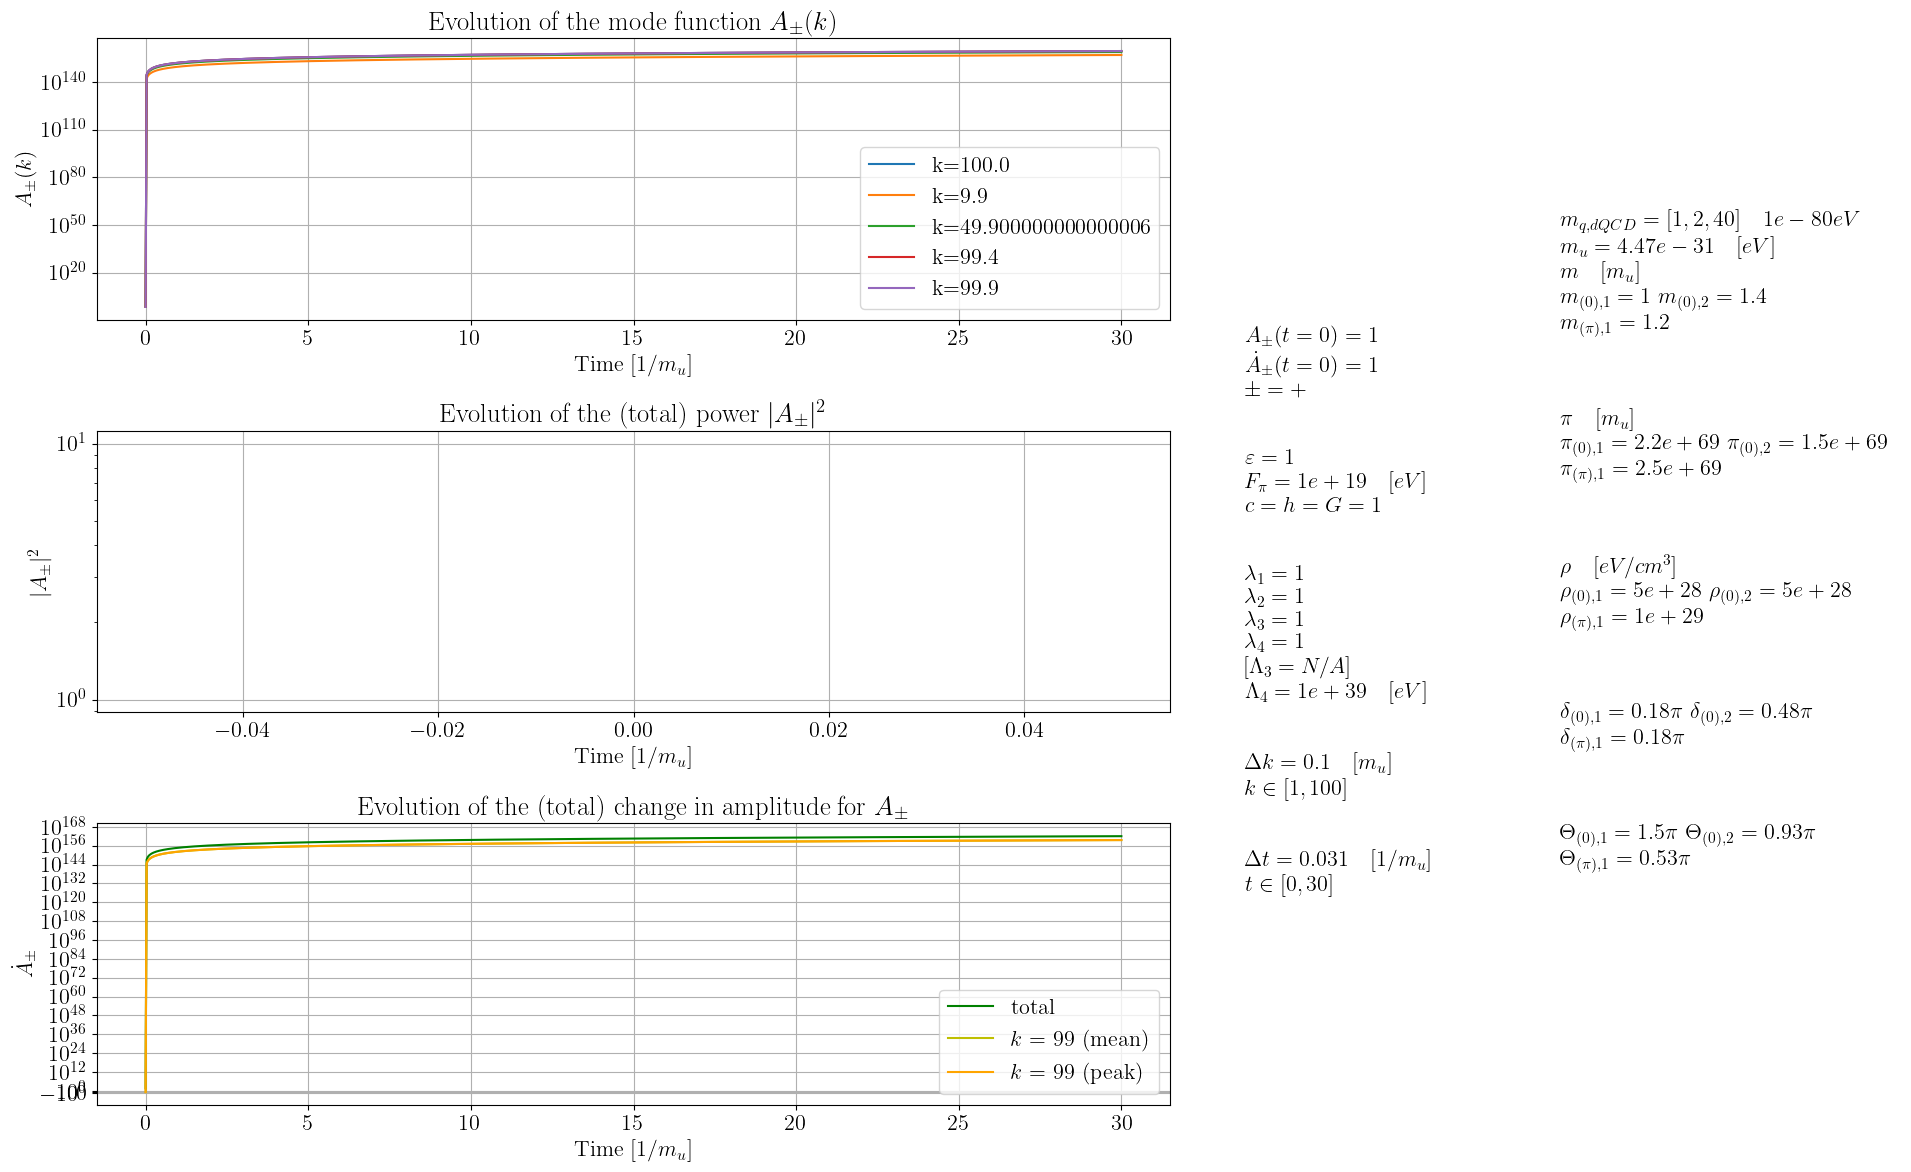

In [19]:
# Plot results (Amplitudes)
k_peak, k_mean = get_peak_k_modes(params, solutions, k_values_in=k_values, write_to_params=True)

if debug_level > 0:
    print('max (peak) k mode: ' + str(k_peak))
    print('max (mean) k mode: ' + str(k_mean))

# Plot the solution
plt = make_amplitudes_plot(params, units, solutions, tex_fmt=use_tex_format)
result_plots['amps'] = plt.gcf()
plt.show()

tot_class: %s resonance
ratio_f: %.2e inf
ratio_m: %.2e inf
t_res: %.3f 0.03003003003003003
t_max: %.3f 0.03003003003003003
n_res: inf
n_max: inf
res  | t: 0.03    n = inf
max  | t: 0.03    n = inf
res condition: 1000000.0
class =  resonance => resonance


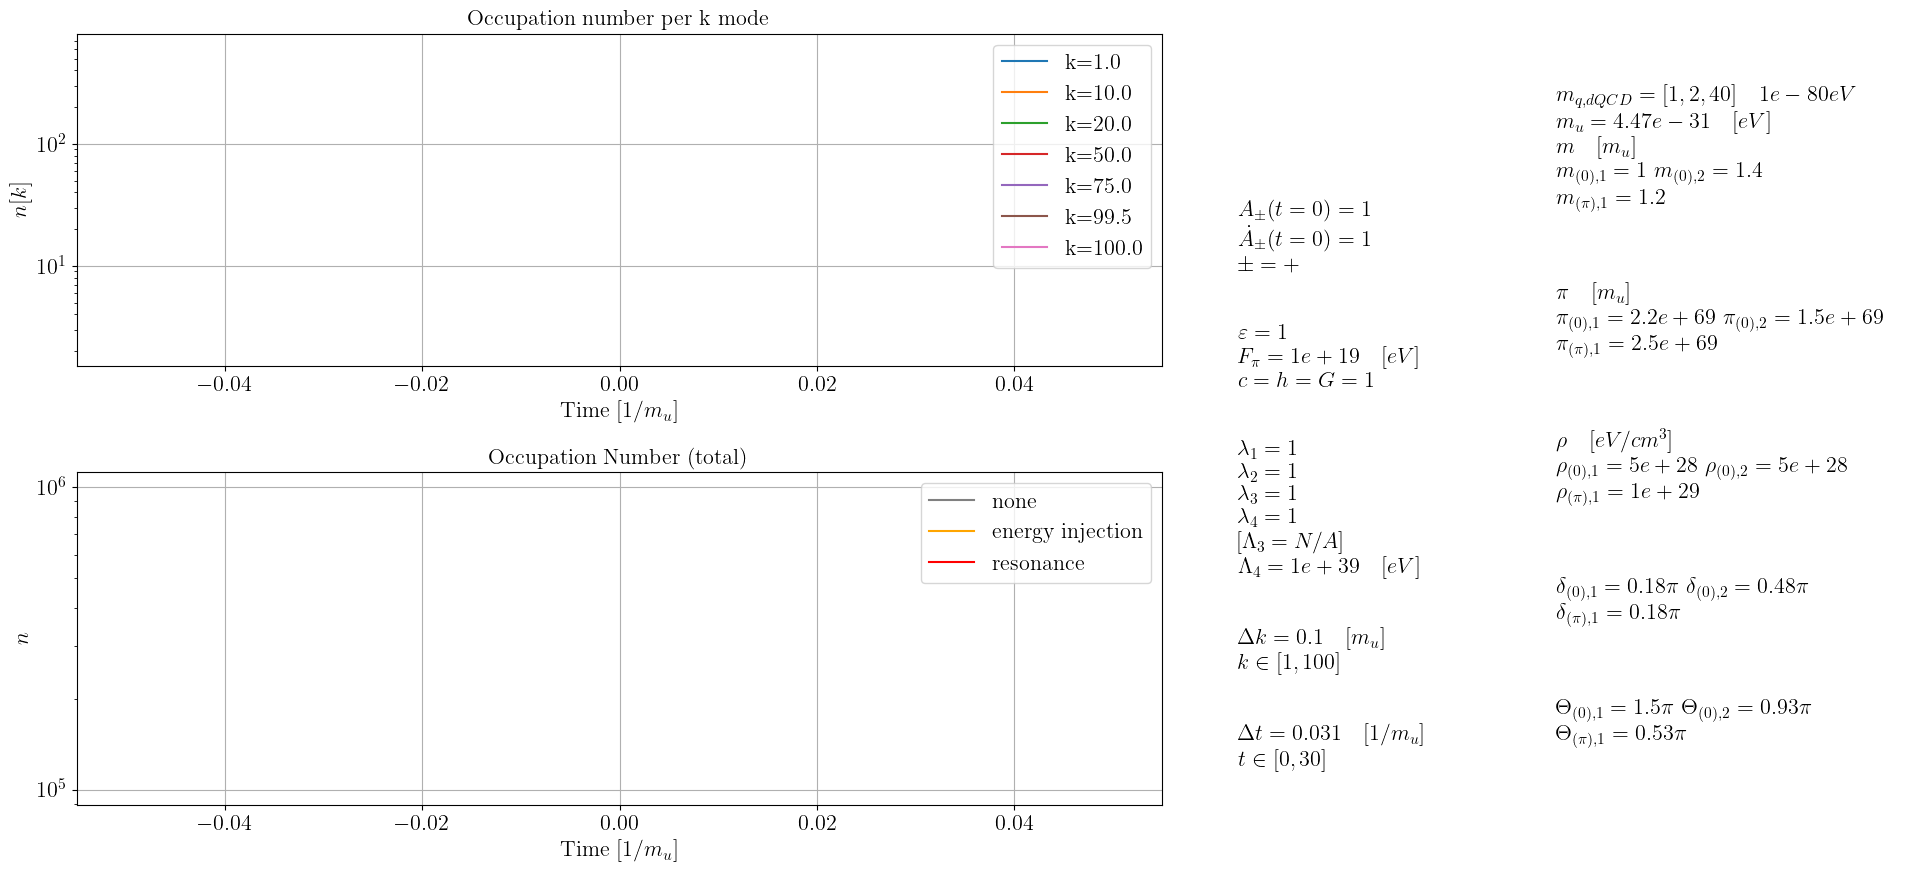

n_tot in range [2.98e+05, inf]
classification: resonance
resonance classification begins at t = 0.03, n = inf


In [20]:
# Plot the occupation numbers
override_n_k = False

# Override particle occupation number function
# TODO: Verify we are using the right particle number/vacuum state definition for our theory
if override_n_k:
    ## Particle number for k_mode value at index i
    
    # original rough sketch from first meeting
    #n_k_local = lambda k, A, Adot, Im=None: (1/2)*(k**2 * np.abs(A)**2 + np.abs(Adot) + k)
   
    # Definition taken from code with both A terms squared (Typo?)
    n_k_local = lambda k, A, Adot, Im: (k**2 * np.abs(A)**2 + np.abs(Adot)**2 - 2*k*Im(k))

    # Alternate definition from https://arxiv.org/abs/1607.00334
    #n_k_local = lambda k, A, Adot, Im=None, h=h_raw: ((k/h)/2)*(np.abs(A)**2 + np.abs(Adot)**2/((k/h)**2)) - (1/2)
else:
    from piaxi_utils import n_k
    n_k_local = n_k
    
times = t

scale_n = False
plt, params, t_res, n_res = make_occupation_num_plots(params, units, solutions, numf_in=n_k_local, times_in=times, scale_n=scale_n, write_to_params=True, tex_fmt=use_tex_format)
n_tot = sum_n_p(n_k_local, params, solutions, k_values, times)

tot_res = params['res_class']
result_plots['nums'] = plt.gcf()
plt.show()

print('n_tot in range [%.2e, %.2e]' % (min(n_tot), max(n_tot)))
print('classification: %s' % tot_res)
if 'res' in tot_res and debug_level > 2:
    print('resonance classification begins at t = %.2f, n = %.2e' % (t_res, n_res))

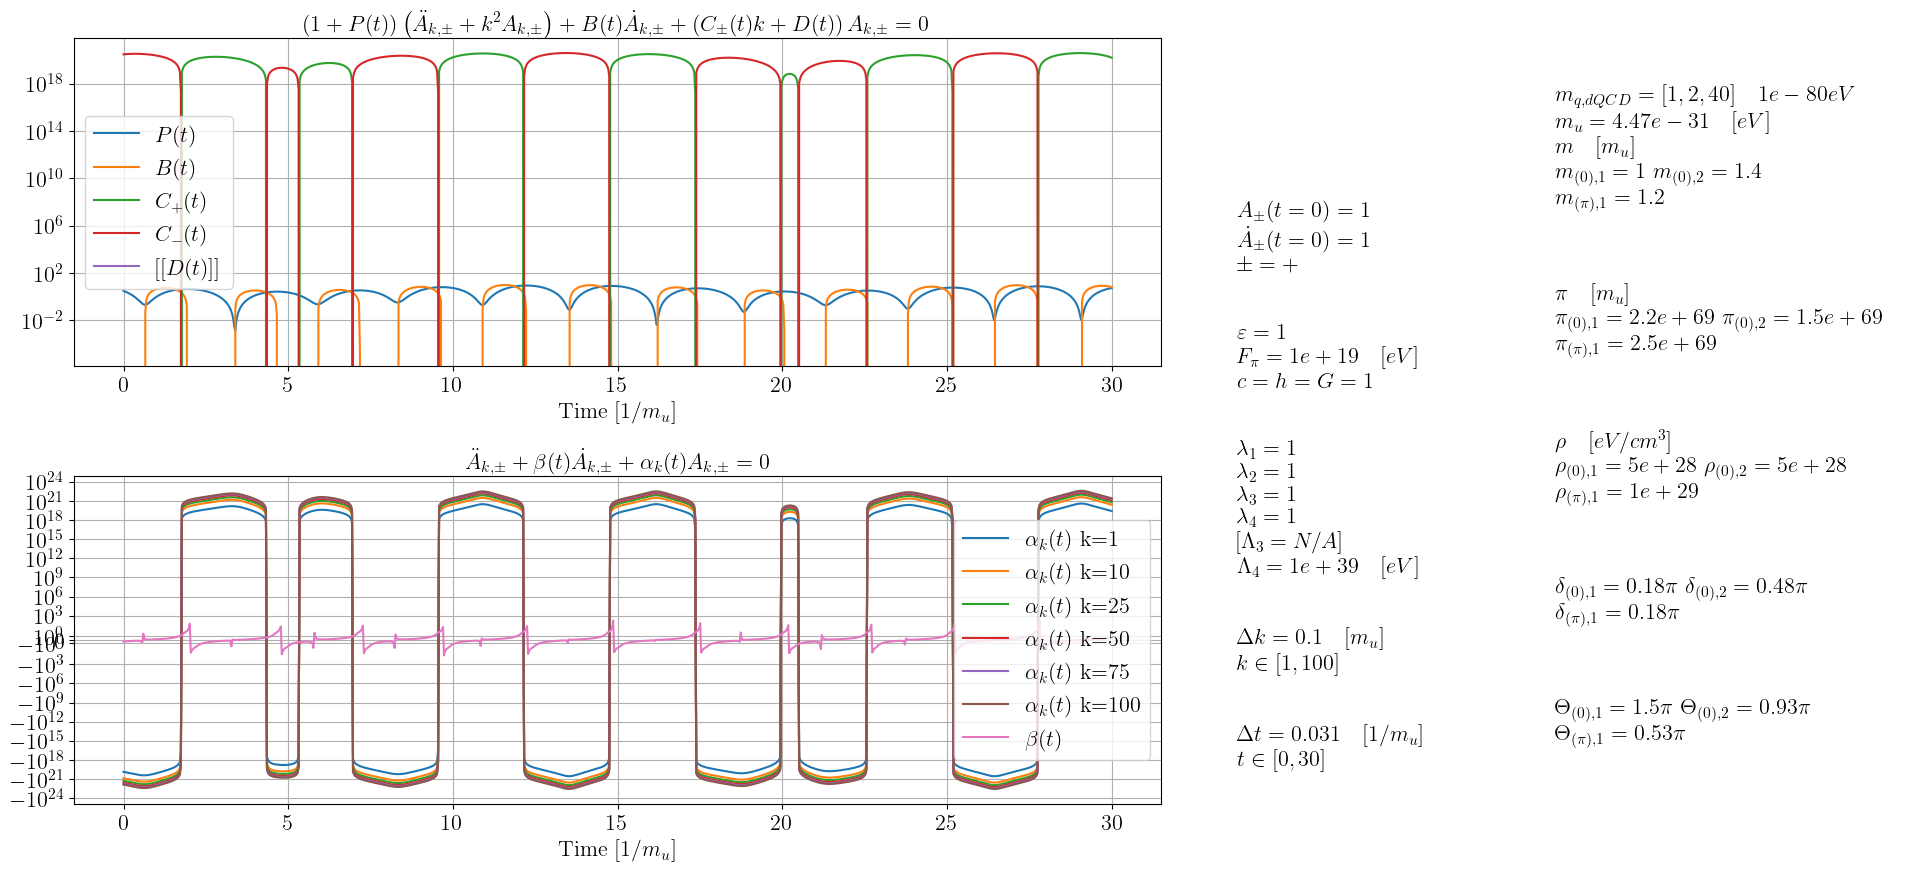

P(t) range: [1.2e-03, 8.5e+00]
B(t) range: [-9.8e+00, 9.5e+00]
C(t) range: [-3.9e+20, 3.8e+20] for + case 
C(t) range: [-3.8e+20, 3.9e+20] for - case 
D(t) range: [nan, nan]
------------------------------------------------------
Alpha(t,k) range: [-3.6e+20, 3.8e+20] when k = 1
Alpha(t,k) range: [-3.6e+21, 3.8e+21] when k = 10
Alpha(t,k) range: [-7.3e+21, 7.6e+21] when k = 20
Alpha(t,k) range: [-1.8e+22, 1.9e+22] when k = 50
Alpha(t,k) range: [-2.7e+22, 2.8e+22] when k = 75
Alpha(t,k) range: [-3.6e+22, 3.8e+22] when k = 100
Beta(t)    range: [-4.0e+01, 1.7e+02]


In [21]:
# Plot results (Oscillating coefficient values)
plt = make_coefficients_plot(params, units, P, B, C, D, A_pm, k0, tex_fmt=use_tex_format)
result_plots['coeffs'] = plt.gcf()
plt.show()

if debug_level == 2:
    print_coefficient_ranges(params, P, B, C, D)
elif debug_level > 2:
    print_coefficient_ranges(params, P, B, C, D, print_all=True)

params['res_class']:
 resonance


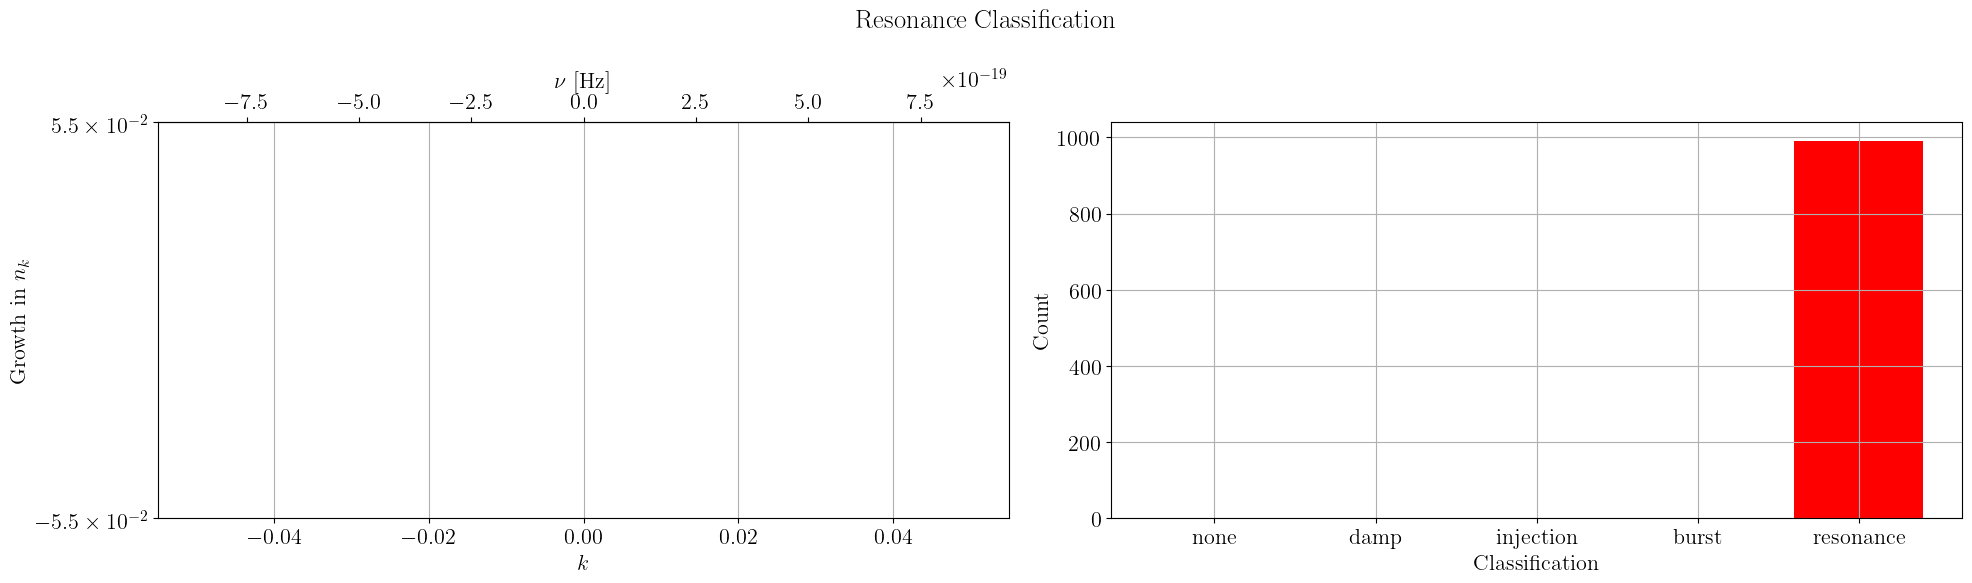

peak resonance at k = 99 corresponds to photon frequency at 1.71e-15 Hz (Radio)


In [22]:
if debug_level > 7:
    print('params:\n', params, '\n')
if debug_level > 2:
    print('params[\'res_class\']:\n', params['res_class'])
    if debug_level > 6:
        print('params[\'k_class_arr\']:\n', params['k_class_arr'])
        print('params[\'k_ratio_arr\']:\n', params['k_ratio_arr'])

# E^2 = p^2c^2 + m^2c^4
# Assuming k, m are given in units of eV/c and eV/c^2 respectively
#k_to_Hz = lambda ki, mi=0, m_0=m0, e=e: 1/h * np.sqrt((ki*k0*e)**2 + ((mi*m_0 * e))**2)
k_to_Hz_local = lambda ki, k0=k0_raw, h=h_raw, c=c_raw: k_to_Hz(ki, k0, h, c)
#Hz_to_k = lambda fi, mi=0, m_0=m0, e=e: 1/(e*k0) * np.sqrt((h * fi)**2 - ((mi*m_0 * e))**2)
Hz_to_k_local = lambda fi, k0=k0_raw, h=h_raw, c=c_raw: Hz_to_k(fi, k0, h, c)

# Plot k-mode power spectrum (TODO: Verify power spectrum calculation)
plt = make_resonance_spectrum(params, units, solutions, k_to_Hz_local, Hz_to_k_local, numf_in=n_k_local, tex_fmt=use_tex_format)
result_plots['resonance'] = plt.gcf()
plt.show()

class_sens = 0.1
# Known observable frequency range and bandwidth classification
res_freq_label, res_freq_class = get_frequency_class(k_peak, k_to_Hz_local, tot_res, verbosity=verbosity)
res_band_min, res_band_max, res_band_class = get_resonance_band(k_values, params['k_class_arr'], k_to_Hz_local, class_sens, verbosity=9)

params['res_freq'] = k_to_Hz_local(k_peak)
params['res_freq_label'] = res_freq_label
params['res_band'] = [res_band_min, res_band_max]
params['res_freq_class'] = res_freq_class
params['res_band_class'] = res_band_class

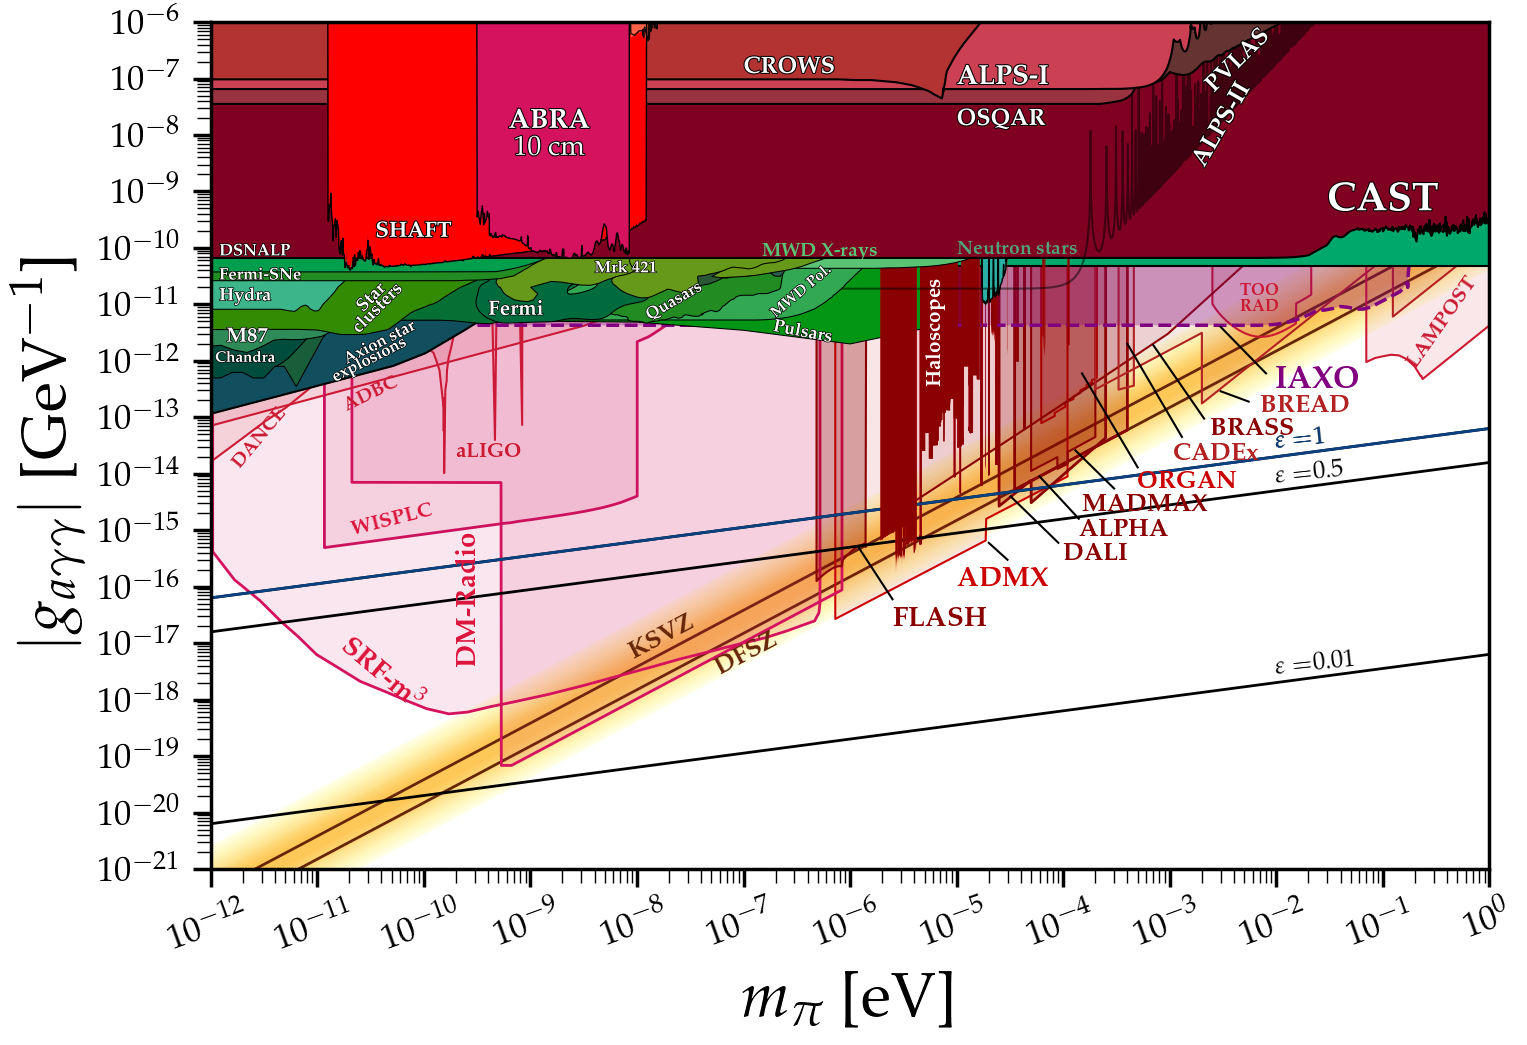

F_pi fit:      False
QCD axion fit: False


In [23]:
## Plot Axion-Photon coupling alongside experimental limits
if N_r > 0:
    plt = plot_ALP_survey(params, verbosity=verbosity, tex_fmt=use_tex_format)
    
    result_plots['alp'] = plt.gcf()
    plt.show()
    
    # Do mass/coupling relations obey constraints on F_pi in this region of parameter space?
    from piaxi_utils import check_Fpi_fit
    fit_sens=2.
    print('F_pi fit:     ', check_Fpi_fit(params['eps'], params['m_u'], params['l1'], params['F'], sens=fit_sens, fit_QCD=False, verbosity=0))
    print('QCD axion fit:', check_Fpi_fit(params['eps'], params['m_u'], params['l1'], params['F'], sens=fit_sens, fit_QCD=True,  verbosity=0))

In [24]:
# Optionally save results of this run to data directory
save_input_params = True
save_integrations = True
save_output_plots = True
use_longterm_data = False

if save_output_files:
    storage_path = data_path if use_longterm_data else '~/scratch'
    output_dir   = '/'.join(storage_path.split('/')) + '/' + version + '/' + config_name + '/'
    output_name  = '_'.join([config_name, phash])
    
    save_results(output_dir, output_name, params, solutions, result_plots, verbosity=debug_level, save_format='pdf',
                 save_params=save_input_params, save_results=save_integrations, save_plots=save_output_plots, 
                 save_coefficients=True, P=P, B=B, C=C, D=D)
    
    # Save plots (PDF or HTML or PNG or Notebook?)
    # (TODO)

Results saved to /users/sloane1/scratch/v3.2.6/pi_axiverse_jupyter_debug/
Files saved:                                                                      | (Total: 17.0MiB)
  pi_axiverse_jupyter_debug_5896a9f70c61ee6498dd3b515c33d584daf962d6.json         | 109.5KiB
  pi_axiverse_jupyter_debug_5896a9f70c61ee6498dd3b515c33d584daf962d6.npy          | 15.1MiB
  pi_axiverse_jupyter_debug_5896a9f70c61ee6498dd3b515c33d584daf962d6_funcs.pkl    | 12.6KiB
  pi_axiverse_jupyter_debug_5896a9f70c61ee6498dd3b515c33d584daf962d6_plots.pdf    | 1.8MiB


In [25]:
# WIP: A_dot average
if False:
    from piaxi_utils import signstr as signdict
    N_k = len(k_values)
    sol_arr = np.array(solutions)
    A_dims = (sol_arr.shape[0], sol_arr.shape[-1])
    A_d = np.reshape(np.delete(sol_arr, 1, axis=1), A_dims)
    print(A_d.shape)
    rms = lambda a_in, t_in=times: np.sqrt(np.trapz(a_in**2, t_in)/(t_in[-1] - t_in[0]))
    a_rms = lambda a_in, t_in=times, N=N_k: np.array([[rms(a_in[ki,:ti], t_in[:ti]) if ti > 1 else np.abs(a_in[ki,ti]) for ti, td in enumerate(t_in)] for ki in np.arange(N)])
    avg = lambda a_in, m, Nt=len(times), N=N_k: np.array([np.convolve(a_in[ki], np.ones(int(Nt))/Nt, mode=m) for ki in np.arange(N)])
    
    plt.figure(figsize=(18, 10))
    
    # TODO: Plot running averages
    for mode, ls in [('full','solid'), ('same','--'), ('valid',':')]:
        print(mode)
        A_d_avg   = avg(A_d, mode)
        A_d_avg_1 = np.sum(A_d_avg, axis=0)
        #A_d_avg_2 = avg(np.reshape(np.sum(A_d, axis=0), (1, A_d.shape[-1])), mode, N=1)[0]
        avg_times = np.linspace(times[0], times[-1], num=A_d_avg.shape[-1])
        print(A_d_avg.shape)
        print(A_d_avg_1.shape)
        print(A_d_avg_2.shape)
        plt.plot(avg_times, A_d_avg_1, label=r'avg_1 (%s) total' % mode, linestyle=ls, color='blue')
        #plt.plot(avg_times, A_d_avg_2, label=r'avg_2 (%s) total' % mode, linestyle=ls, color='red')
        plt.plot(avg_times, A_d_avg[list(k_values).index(k_peak)], label=r'avg (%s) peak' % mode, linestyle=ls, color='yellow')
        plt.plot(avg_times, A_d_avg[list(k_values).index(k_mean)], label=r'avg (%s) mean' % mode, linestyle=ls, color='orange')
    
    plt.title(r'Evolution of the (total) change in amplitude for $A[%s]$' % signdict[0])
    plt.xlabel(r'Time $[%s]$' % units['t'])
    plt.ylabel(r'$<\dot{A}_{%s}>$' % signdict[0])
    plt.yscale('log')
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [26]:
if False:
    # neutral (real), neutral (complex), and charged species masses in [eV]
    N_r = 5; N_n = 6; N_c = 9
    example_m_r = 1e-5  # [eV]
    example_m_n = 2e-5  # [eV]
    example_m_c = 3e-5  # [eV]
    
    # example species sets
    example_masses = [example_m_r]*N_r + [example_m_n]*N_n + [example_m_c]*N_c
    example_amps = [2*np.sqrt(density_example)/example_m_r]*N_r + [2*np.sqrt(density_example)/example_m_n]*N_n + [2*np.sqrt(density_example)/example_m_c]*N_c
    #example_phases = [0.]*N_r + [0.]*N_n + [0.]*N_c
    example_phases = np.mod(np.random.uniform(0, 2*np.pi, (N_r+N_n+N_c)), 2*np.pi)
    example_lambdas = [l4]*N_r + [l4]*N_n + [l3]*N_c
    example_Lambdas = [L4]*N_r + [L4]*N_n + [L3]*N_c

Fine Structure Constant Oscillations: 
    alpha_SM     = 7.3e-03 
    alpha_e(t=0) = 2.2e+58 


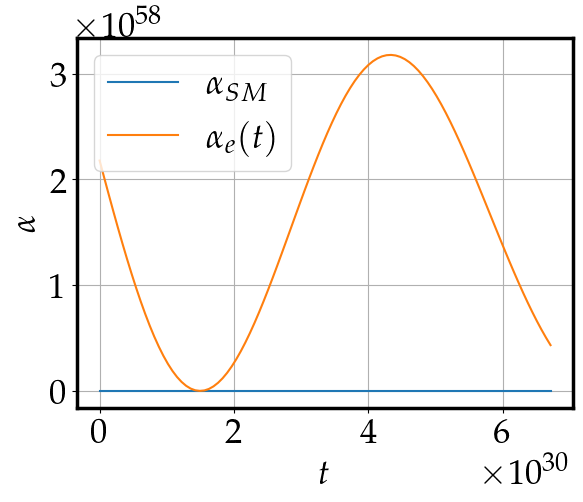

FS constant oscillations observable?
  Neutral species (L4 = 1.0e+39 [eV])
    m_0 = 4.5e-31 [eV]  -->  True
    m_0 = 6.3e-31 [eV]  -->  True
    m_π = 5.5e-31 [eV]  -->  True


In [27]:
## Fine Structure Constant corrections
fs_correction_manual = False
if fs_correction_manual:
    from piaxi_utils import piaxi_fs
    
    l_flat = np.array([l4]*N_r + [l4]*N_n + [l3]*N_c)
    L_flat = np.array([L4]*N_r + [L4]*N_n + [L3]*N_c)
    c_flat = np.array([0]*N_r  + [0]*N_n  + [1]*N_c)
    flatten = lambda x: np.array([x_i for x_s in x for x_i in x_s])
    amps_flat = flatten(amps)
    m_flat    = flatten(m)
    d_flat    = flatten(d)
    
    # NOTE: at the time of writing, this is an incomplete/erroneous definition for alpha_e (missing off-diagonal terms)
    alpha_e    = lambda t: piaxi_fs(t, lambdas=l_flat, Lambdas=L_flat, e=e, eps=eps, amps=amps_flat, masses=m_flat, phases=d_flat, charges=c_flat)
    alpha_off  = lambda t: 1.
    alpha_sm   = lambda t: 1./137
    
    print('Fine Structure Constant Oscillations: ')
    print('    alpha_SM     = %.1e ' % alpha_sm(t=0))
    print('    alpha_e(t=0) = %.1e ' % alpha_e(t=0))
    
    # Show plot of alpha
    import matplotlib.pyplot as plt
    fs_t = np.linspace(0,  2*np.pi/m_u, 100)
    plt.plot(fs_t, [alpha_sm(t) for t in fs_t], label=r'$\alpha_{SM}$')
    plt.plot(fs_t, [alpha_e(t) for t in fs_t], label=r'$\alpha_{e}(t)$')
    plt.grid()
    plt.legend()
else:
    from piaxi_utils import plot_fs_constant
    plt = plot_fs_constant(params, verbosity=9, return_plot=True)
plt.show()

# Fine-structure constant oscillations (Van Tilberg et al, 2015)
is_alpha_e_observable = lambda m_i, rho_i, L, eps=eps: (rho_i * eps**2) / (L**2 * m_i**2) > 1e-16

print('FS constant oscillations observable?')
if (N_r > 0) or (N_n > 0):
    print('  Neutral species (L4 = %.1e [eV])' % L4)
    if N_r > 0:
        for mr_in, pr_in in zip(m[0], p[0]):
            print('    m_0 = %.1e [eV]  -->  %s' % (mr_in, is_alpha_e_observable(mr_in, pr_in, L4)))
    if N_n > 0:
        for mn_in, pn_in in zip(m[1], p[1]):
            print('    m_π = %.1e [eV]  -->  %s' % (mn_in, is_alpha_e_observable(mn_in, pn_in, L4)))
if (N_c > 0):
    print('  Charged species (L3 = %.1e [eV])' % L3)
    for mc_in, pc_in in zip(m[2], p[2]):
        print('    m_±  = %.1e [eV]  -->  %s' % (mc_in, is_alpha_e_observable(mc_in, pc_in, L3)))

In [28]:
## Coupling Constants
from piaxi_utils import get_coupling_constants
g_0, g_2, g_3, g_4 = get_coupling_constants(params)

print('g_anomaly = %s   |   triangle anomaly'   % ('%.1e [eV]' % g_0 if g_0 is not None else 'N/A         '))
print('g_2       = %s   |   scalar QED'         % ('%.1e [eV]' % g_2 if g_2 is not None else 'N/A         '))
print('g_3       = %s   |   charged scattering' % ('%.1e [eV]' % g_3 if g_3 is not None else 'N/A         '))
print('g_4       = %s   |   neutral scattering' % ('%.1e [eV]' % g_4 if g_4 is not None else 'N/A         '))

g_anomaly = 3.6e-22 [eV]   |   triangle anomaly
g_2       = N/A            |   scalar QED
g_3       = N/A            |   charged scattering
g_4       = 1.1e-20 [eV]   |   neutral scattering


In [29]:
### WIP: Consistency checks!
from piaxi_utils import cosmo_stability

## Cosmologically Stable lifetime for neutral species
# m_in = [eV]   |   F_pi = [eV]   |   eps = millicharge
is_cosmo_stable = lambda m_in, F_pi=F, eps=eps: cosmo_stability(m_in, F_pi, eps) <= 1.2

if (N_r > 0) or (N_n > 0):
    print('Neutral species cosmologically stable?')
    if N_r > 0:
        for mr_in in m[0]:
            print('    m_0 = %.1e [eV]  -->  %s' % (mr_in, is_cosmo_stable(mr_in)))
    if N_n > 0:
        for mn_in in m[1]:
            print('    m_π = %.1e [eV]  -->  %s' % (mn_in, is_cosmo_stable(mn_in)))

## Freeze-in Relic Density for charged species
H_infl = 1e19   # Hubble at Inflation [eV]
T_re   = 1e18   # Temperature of reheating [eV]
w_re   = 0      # Equation of state (at reheating)
M_pl   = 1.2e27 # Planck Mass [eV]
rd_a = lambda m_in, H=H_infl, M=M_pl: m_in/np.sqrt(H*M)
rd_b = lambda T=T_re, H=H_infl, M=M_pl: np.sqrt(H*M)/T
relic_density_charged = lambda m_in, F_pi=F, eps=eps, w=w_re, H=H_infl, T=T_re, M=M_pl: \
    (5e-3) * (((10*np.pi**2)**(-w/(1+w)))/(2*(1+w))) * (eps**4) * (np.exp(10*(3-rd_a(m_in,H,M)*np.sqrt(rd_b(T,H,M))))/(rd_b(T,H,M)**(4/(1+w)-(1/2))))
omega_c = np.sum([relic_density_charged(mc_in) for mc_in in m[2]])

if N_c > 0:
    print('Negligible charged DM relic density?')
    for mc_in in m[2]:
        rd_c = relic_density_charged(mc_in)
        print('    m_±  = %.1e [eV]  -->  %s (Omega_DM = %.1e)' % (mc_in, rd_c <= 0.01, rd_c)) 

Neutral species cosmologically stable?
    m_0 = 4.5e-31 [eV]  -->  True
    m_0 = 6.3e-31 [eV]  -->  True
    m_π = 5.5e-31 [eV]  -->  True


In [30]:
### TODO: Dispersion and Birefringence Effects

## e.g. Dispersion relations in non-trivial refractive index (McDonald and Ventura, 2019)

In [31]:
## WIP: Coefficient OoM Estimates

P_oom = lambda p_in, m_in, L_in, eps_in=eps: (p_in * eps_in**2) / (L_in**2 * m_in**2)
P_oom_list = [P_oom(pr_in, mr_in, L4) for mr_in, pr_in in zip(m[0], p[0])] + [P_oom(pr_in, mr_in, L4) for mr_in, pr_in in zip(m[1], p[1])] + [P_oom(pr_in, mr_in, L3) for mr_in, pr_in in zip(m[2], p[2])]
print('P(t) - Order of Magnitude estimate: ~ %.0e' % np.sum(P_oom_list))
if (N_r > 0) or (N_n > 0):
    print('  Neutral species (L4 = %.1e [eV])' % L4)
    if N_r > 0:
        for mr_in, pr_in in zip(m[0], p[0]):
            print('    m_0  = %.1e [eV]  -->  P(t)_i ~ %.0e' % (mr_in, P_oom(pr_in, mr_in, L4)))
    if N_n > 0:
        for mn_in, pn_in in zip(m[1], p[1]):
            print('    m_π  = %.1e [eV]  -->  P(t)_i ~ %.0e' % (mn_in, P_oom(pn_in, mn_in, L4)))
if (N_c > 0):
    print('  Charged species (L3 = %.1e [eV])' % L3)
    for mc_in, pc_in in zip(m[2], p[2]):
        print('    m_±  = %.1e [eV]  -->  P(t)_i ~ %.0e' % (mc_in, P_oom(pc_in, mc_in, L3)))

B_oom = lambda p_in, m_in, L_in, eps_in=eps: (p_in * eps_in**2) / (L_in**2 * m_in)
B_oom_list = [B_oom(pr_in, mr_in, L4) for mr_in, pr_in in zip(m[0], p[0])] + [B_oom(pr_in, mr_in, L4) for mr_in, pr_in in zip(m[1], p[1])] + [B_oom(pr_in, mr_in, L3) for mr_in, pr_in in zip(m[2], p[2])]
print('B(t) - Order of Magnitude estimate: ~ %.0e' % np.sum(B_oom_list))
if (N_r > 0) or (N_n > 0):
    print('  Neutral species (L4 = %.1e [eV])' % L4)
    if N_r > 0:
        for mr_in, pr_in in zip(m[0], p[0]):
            print('    m_0  = %.1e [eV]  -->  B(t)_i ~ %.0e' % (mr_in, B_oom(pr_in, mr_in, L4)))
    if N_n > 0:
        for mn_in, pn_in in zip(m[1], p[1]):
            print('    m_π  = %.1e [eV]  -->  B(t)_i ~ %.0e' % (mn_in, B_oom(pn_in, mn_in, L4)))
if (N_c > 0):
    print('  Charged species (L3 = %.1e [eV])' % L3)
    for mc_in, pc_in in zip(m[2], p[2]):
        print('    m_±  = %.1e [eV]  -->  B(t)_i ~ %.0e' % (mc_in, B_oom(pc_in, mc_in, L3)))

C_oom = lambda p_in, m_in, F_in, eps_in=eps: (np.sqrt(p_in) * eps_in**2) / (F_in)
if (N_r > 0):
    C_oom_list = [C_oom(pr_in, mr_in, F) for mr_in, pr_in in zip(m[0], p[0])]
    print('C±(t) - Order of Magnitude estimate: ~ %.0e' % np.sum(C_oom_list))
    print('  Neutral species')
    for mr_in, C_est in zip(m[0], C_oom_list):
        print('    m_0  = %.1e [eV]  -->  C±(t)_i ~ ±%.0e' % (mr_in, C_est))

D_oom = lambda p_in, m_in, eps_in=eps: (p_in * eps_in**2) / (m_in**2)
if (N_c > 0):
    D_oom_list = [D_oom(pr_in, mr_in) for mr_in, pr_in in zip(m[2], p[2])]
    print('D(t) - Order of Magnitude estimate: ~ %.0e' % np.sum(D_oom_list))
    print('  Charged species')
    for mc_in, D_est in zip(m[2], D_oom_list):
        print('    m_±  = %.1e [eV]  -->  D(t)_i ~ %.0e' % (mc_in, D_est))

if (np.sum(B_oom_list) / (1 + np.sum(P_oom_list))) > 1e3:
    print('Potential Instability Warning: B(t) >> P(t)')
if (N_r > 0):
    if (np.sum(C_oom_list) / (1 + np.sum(P_oom_list))) > 1e3:
        print('Potential Instability Warning: C±(t) >> P(t)')
if (N_c > 0):
    if (np.sum(D_oom_list) / (1 + np.sum(P_oom_list))) > 1e3:
        print('Potential Instability Warning: D(t) >> P(t)')

P(t) - Order of Magnitude estimate: ~ 1e+00
  Neutral species (L4 = 1.0e+39 [eV])
    m_0  = 4.5e-31 [eV]  -->  P(t)_i ~ 5e-01
    m_0  = 6.3e-31 [eV]  -->  P(t)_i ~ 2e-01
    m_π  = 5.5e-31 [eV]  -->  P(t)_i ~ 6e-01
B(t) - Order of Magnitude estimate: ~ 7e-31
  Neutral species (L4 = 1.0e+39 [eV])
    m_0  = 4.5e-31 [eV]  -->  B(t)_i ~ 2e-31
    m_0  = 6.3e-31 [eV]  -->  B(t)_i ~ 2e-31
    m_π  = 5.5e-31 [eV]  -->  B(t)_i ~ 3e-31
C±(t) - Order of Magnitude estimate: ~ 6e-11
  Neutral species
    m_0  = 4.5e-31 [eV]  -->  C±(t)_i ~ ±3e-11
    m_0  = 6.3e-31 [eV]  -->  C±(t)_i ~ ±3e-11


In [32]:
# Calculate phase differences
d_r_diffs = [np.abs(d[0][i]-d[0][j]) for i in range(N_r) for j in range(N_r)]
d_n_diffs = [np.abs(d[1][i]-d[1][j]) for i in range(N_n) for j in range(N_n)]
d_c_diffs = [np.abs(d[2][i]-d[2][j]) for i in range(N_c) for j in range(N_c)]
mean_d_r = np.mean(d_r_diffs) if N_r > 0 else None
var_d_r  = np.var(d_r_diffs)  if N_r > 0 else None
#mean_d_n = np.mean(d_n_diffs)
mean_d_n = np.mean(d_r_diffs + d_n_diffs + [np.abs(d[0][i]-d[1][j]) for i in range(N_r) for j in range(N_n)]) if N_r > 0 else d_n_diffs if N_n > 0 else None
var_d_n  = np.var(d_r_diffs + d_n_diffs + [np.abs(d[0][i]-d[1][j]) for i in range(N_r) for j in range(N_n)])  if N_r > 0 else d_n_diffs if N_n > 0 else None
mean_d_c = np.mean(d_c_diffs) if N_c > 0 else None
var_d_c  = np.var(d_c_diffs)  if N_c > 0 else None

Th_n_diffs = [np.abs(Th[1][i]-Th[1][j]) for i in range(N_n) for j in range(N_n)]
Th_c_diffs = [np.abs(Th[2][i]-Th[2][j]) for i in range(N_c) for j in range(N_c)]
mean_Th_n = np.mean(Th_n_diffs) if N_n > 0 else None
var_Th_n  = np.var(Th_n_diffs)  if N_n > 0 else None
mean_Th_c = np.mean(Th_c_diffs) if N_c > 0 else None
var_Th_c  = np.var(Th_c_diffs)  if N_c > 0 else None
#mean_Th_c = np.mean(Th_c_diffs + Th_n_diffs + [np.abs(Th[2][i]-Th[1][j]) for i in range(N_c) for j in range(N_n)]) if N_n > 0 else Th_c_diffs if N_c > 0 else None

print('mean and variance: |δ_i - δ_j|')
print('  reals    | %s%s' % (('mean: %.2f π' % (mean_d_r/np.pi) if mean_d_r is not None else mean_d_r), ('       var: %.2f π' % (var_d_r/np.pi) if var_d_r is not None else '')))
print('  neutrals | %s%s' % (('mean: %.2f π' % (mean_d_n/np.pi) if mean_d_n is not None else mean_d_n), ('       var: %.2f π' % (var_d_n/np.pi) if var_d_n is not None else '')))
print('  charged  | %s%s' % (('mean: %.2f π' % (mean_d_c/np.pi) if mean_d_c is not None else mean_d_c), ('       var: %.2f π' % (var_d_c/np.pi) if var_d_c is not None else '')))

print('mean and variance: |θ_i - θ_j|')
print('  neutrals | %s%s' % (('mean: %.2f π' % (mean_Th_n/np.pi) if mean_Th_n is not None else mean_Th_n), ('       var: %.2f π' % (var_Th_n/np.pi) if var_Th_n is not None else '')))
print('  charged  | %s%s' % (('mean: %.2f π' % (mean_Th_c/np.pi) if mean_Th_c is not None else mean_Th_c), ('       var: %.2f π' % (var_Th_c/np.pi) if var_Th_c is not None else '')))

mean and variance: |δ_i - δ_j|
  reals    | mean: 0.15 π       var: 0.07 π
  neutrals | mean: 0.13 π       var: 0.07 π
  charged  | None
mean and variance: |θ_i - θ_j|
  neutrals | mean: 0.00 π       var: 0.00 π
  charged  | None


In [33]:
# WIP: Axion Star properties (from Di and Shi, 2023)
# NOTE: These relations may need to be adjusted for cases beyond just a single, real, QCD-scale axion

# Mass [Solar Mass]
AS_m = lambda m_in=m_u, f_in=F: 1.2e-6 * (m_in/1e-8)**(-1) * (f_in/1e23)
# Mass [km]
AS_r = lambda m_in=m_u, f_in=F: 7.8e2 * (m_in/1e-8)**(-1) * (f_in/1e23)**(-1)

print('Maximum AS size, when m = %.1e [eV] and F_pi = %.1e [eV]' % (m_u, F))
print('     mass: %.2e [Solar Mass]' % AS_m())
print('   radius: %.2e [km]' % AS_r())

# Bounds on Planet 9 estimated mass [Solar Mass]
p9_mrange = (1.0e-5, 5e-5)
print('Possible Planet 9 candidate?')
print('   --> %s' % ((AS_m() >= p9_mrange[0]) and (AS_m() <= p9_mrange[1])))

Maximum AS size, when m = 4.5e-31 [eV] and F_pi = 1.0e+19 [eV]
     mass: 2.68e+12 [Solar Mass]
   radius: 1.74e+29 [km]
Possible Planet 9 candidate?
   --> False


In [34]:
## WIP: Current/Future Detector sensetivities

## Radio detector frequency ranges, in [Hz]
detectors = [
    {'observatory': 'SKA',      'name': 'SKA_low',     'range': (50e6, 350e6),     'class': 'radio', 'location': 'Africa',         'status':'Planned',      'fullname': 'Square Kilometre Array Lowrange Frequency'},
    {'observatory': 'SKA',      'name': 'SKA_mid',     'range': (350e6, 14e9),     'class': 'radio', 'location': 'Africa',         'status':'Planned',      'fullname': 'Square Kilometre Array Midrange Frequency'},
    {'observatory': 'SKA',      'name': 'SKA_survey',  'range': (350e6, 4e9),      'class': 'radio', 'location': 'Africa',         'status':'Operational',  'fullname': 'Square Kilometre Array Survey Telescope'},
    {'observatory': 'SKA',      'name': 'ASKAP',       'range': (700e6, 1800e6),   'class': 'radio', 'location': 'Africa',         'status':'',             'fullname': ''},
    {'observatory': 'FAST',     'name': 'FAST',        'range': (70e6, 3e9),       'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'FAST',     'name': 'FLAN',        'range': (1.05e9, 1.45e9),  'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'CHIME',    'name': 'CHIME',       'range': (400e6, 800e6),    'class': 'radio', 'location': '',               'status':'Operational',  'fullname': ''},
    {'observatory': 'C-BASS',   'name': 'CBASS',       'range': (4.5e9, 5.5e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'HERA',     'name': 'HERA',        'range': (50e6, 200e6),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'MeerKAT',  'name': 'KAT7',        'range': (0.9e9, 1.6e9),    'class': 'radio', 'location': '',               'status':'Operational',  'fullname': ''},
    {'observatory': 'MeerKAT',  'name': 'MeerKAT',     'range': (0.58e9, 14.5e9),  'class': 'radio', 'location': 'Africa',         'status':'',             'fullname': ''},
    {'observatory': 'DASI',     'name': 'DASI',        'range': (26e9, 36e9),      'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'SPT',      'name': 'SPT',         'range': (95e9, 350e9),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'PaST',     'name': 'PAST',        'range': (50e6, 200e6),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'GMRT',     'name': 'GMRT',        'range': (50e6, 1420e6),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'Nobeyama', 'name': 'NRO',         'range': (17e9, 115e9),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'RSDN',     'name': 'RT70',        'range': (5e9, 300e9),      'class': 'radio', 'location': '',               'status':'Operational',  'fullname': 'Russian Deep Space Network RT-70'},
    {'observatory': 'Qitai',    'name': 'QTT',         'range': (150e6, 115e9),    'class': 'radio', 'location': 'Asia',           'status':'',             'fullname': ''},
    {'observatory': 'NARIT',    'name': 'NARIT',       'range': (300e6, 115e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'VERA',     'name': 'VERA',        'range': (6.7e9, 43e9),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'MERLIN',   'name': 'MERLIN',      'range': (151e6, 24e9),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'IRAM',     'name': 'IRAM',        'range': (100e9, 300e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'ASTRON',   'name': 'WSRT',        'range': (120e6, 8.3e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'ASTRON',   'name': 'LOFAR',       'range': (10e6, 240e6),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'GBT',      'name': 'GBT',         'range': (0.1e9, 116e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'VLA',      'name': 'VLA',         'range': (73e6, 50e9),      'class': 'radio', 'location': '',               'status':'',             'fullname': 'Very Large Array'},
    {'observatory': 'LWA',      'name': 'LWA',         'range': (10e6, 88e6),      'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'LCRT',     'name': 'LCRT',        'range': (1e6, 30e6),       'class': 'radio', 'location': 'Moon',           'status':'Planned',      'fullname': 'Lunar Crater Radio Telescope'},
    {'observatory': 'VSA',      'name': 'VSA',         'range': (25e9, 36e9),      'class': 'radio', 'location': 'Europe',         'status':'',             'fullname': 'Very Small Array'},
    {'observatory': 'Atacama',  'name': 'ACT',         'range': (27e9, 277e9),     'class': 'radio', 'location': 'South America',  'status':'',             'fullname': ''},
    {'observatory': 'Atacama',  'name': 'ABS',         'range': (127e9, 163e9),    'class': 'radio', 'location': 'South America',  'status':'',             'fullname': ''},
    {'observatory': 'Atacama',  'name': 'ALMA',        'range': (35e9, 950e9),     'class': 'radio', 'location': 'South America',  'status':'',             'fullname': ''},
    {'observatory': 'Atacama',  'name': 'APEX',        'range': (159e9, 738e9),    'class': 'radio', 'location': 'South America',  'status':'',             'fullname': ''},
    {'observatory': 'BINGO',    'name': 'BINGO',       'range': (980e6, 1260e6),   'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'CLASS',    'name': 'CLASS',       'range': (30e9, 240e9),     'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'SMA',      'name': 'SMA',         'range': (180e9, 420e9),    'class': 'radio', 'location': '',               'status':'',             'fullname': ''},
    {'observatory': 'LLAMA',    'name': 'LLAMA',       'range': (45e9, 900e9),     'class': 'radio', 'location': 'South America',  'status':'Planned',      'fullname': ''}]
detectors_df = pd.DataFrame(detectors)

# Omit certain columns and format for printing
print_df = pd.DataFrame(detectors_df, copy=True)
print_df['range']    = detectors_df['range'].apply(lambda x: '%.2e  %.2e' % x)
print_df['minrange'] = detectors_df['range'].apply(lambda x: '%.2e' % x[0])
print_df['maxrange'] = detectors_df['range'].apply(lambda x: '%.2e' % x[1])
print_df.drop(columns=['range', 'fullname', 'class', 'observatory'], inplace=True)
print(print_df)

          name       location       status  minrange  maxrange
0      SKA_low         Africa      Planned  5.00e+07  3.50e+08
1      SKA_mid         Africa      Planned  3.50e+08  1.40e+10
2   SKA_survey         Africa  Operational  3.50e+08  4.00e+09
3        ASKAP         Africa               7.00e+08  1.80e+09
4         FAST                              7.00e+07  3.00e+09
5         FLAN                              1.05e+09  1.45e+09
6        CHIME                 Operational  4.00e+08  8.00e+08
7        CBASS                              4.50e+09  5.50e+09
8         HERA                              5.00e+07  2.00e+08
9         KAT7                 Operational  9.00e+08  1.60e+09
10     MeerKAT         Africa               5.80e+08  1.45e+10
11        DASI                              2.60e+10  3.60e+10
12         SPT                              9.50e+10  3.50e+11
13        PAST                              5.00e+07  2.00e+08
14        GMRT                              5.00e+07  1